In [ ]:
# %matplotlib inline
import torch
from torch.utils.data import DataLoader
from models import get_model
from trainers import get_trainer
from evaluation.eval import evaluate_models
import torchvision.transforms as transforms
from data import Augmentor
import os
import zipfile

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 50
IMG_SIZE = 168
FOOTAGE_ID = "hall1" 

print(f"Using device: {DEVICE}\n")

Using device: cuda



Generating augmented data to: ./datasets/I2R_Frames/hall1_Rot10_TPS0_El0


Augmenting: 100%|██████████| 200/200 [00:06<00:00, 29.84it/s]


Loaded Flat Dataset: 200 images from 'hall1_Rot10_TPS0_El0'.
Visualizing images from local index 0...


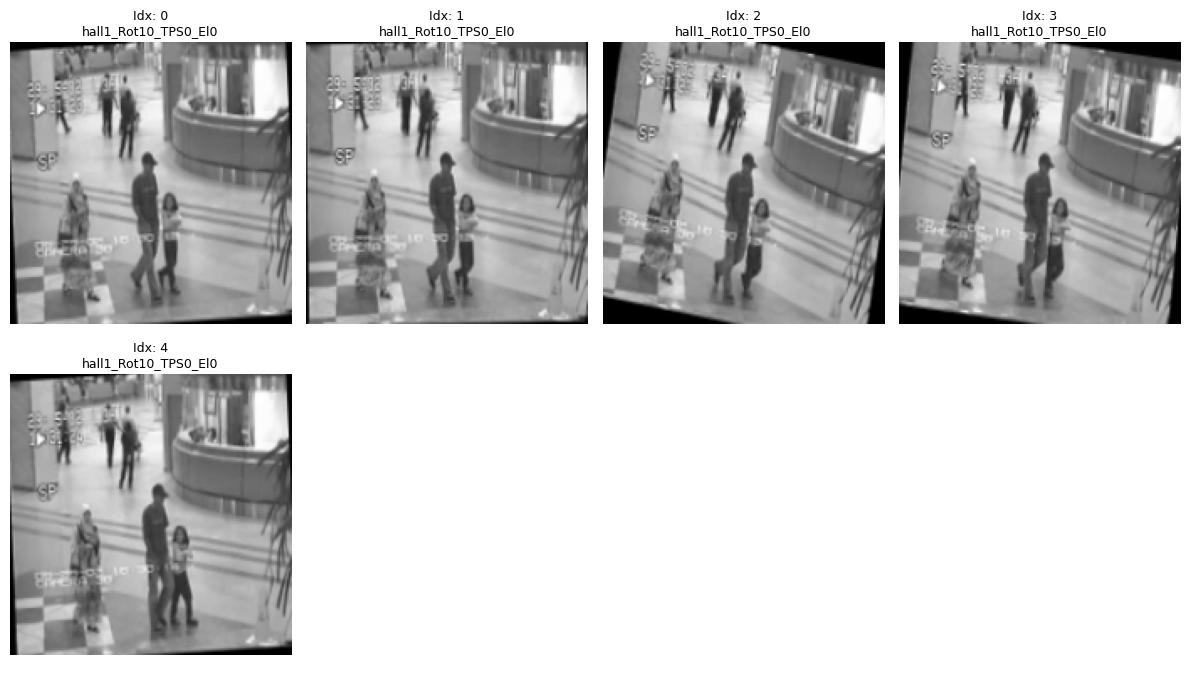

In [ ]:
if os.path.exists("./datasets/I2R_Frames") is False:
    with zipfile.ZipFile("./datasets/I2R_Frames.zip", 'r') as zip_ref:
        zip_ref.extractall("./datasets/")


aug = Augmentor(rotation=10, source_root=f"./datasets/I2R_Frames/{FOOTAGE_ID}", device=DEVICE)

i2r_data = aug.get_dataset(
    transform=transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
)

i2r_loader = DataLoader(
    i2r_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    i2r_data,
    batch_size=len(i2r_data),
    shuffle=False
)

i2r_data.visualize(num_images=5)

In [4]:
ae_params = {
        'latent_dim': 8,
        'dropout': 0.33,
        'std': 0.5,
        'lr': 2e-4,
        'lambda_': 0.003,
        'outer_epochs': 4,
        'inner_epochs': 15,
    }

Using parameters: {'latent_dim': 8, 'dropout': 0.33, 'std': 0.5, 'lr': 0.0002, 'lambda_': 0.003, 'outer_epochs': 4, 'inner_epochs': 15}

Training with cuda:0

Training with ADMM Algorithm (l1 norm)...


ADMM Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Step 1: Training AE:   0%|          | 0/15 [00:00<?, ?it/s]

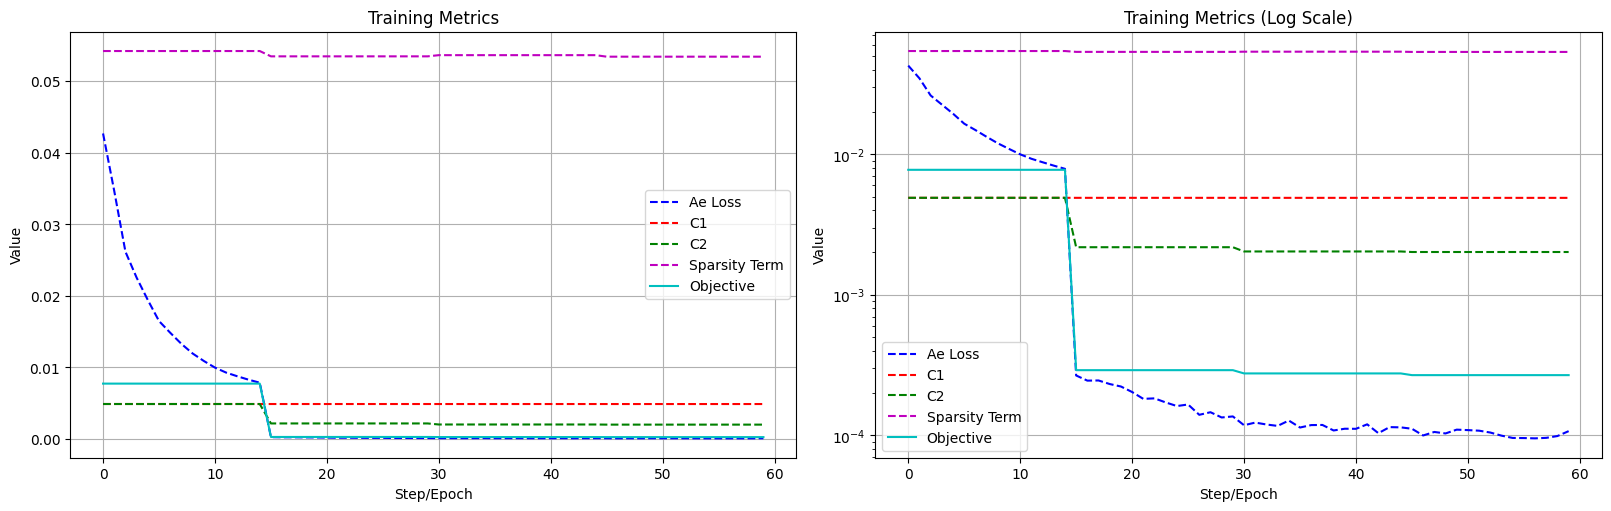

Step 2: Training AE:   0%|          | 0/15 [00:00<?, ?it/s]

Step 3: Training AE:   0%|          | 0/15 [00:00<?, ?it/s]

Step 4: Training AE:   0%|          | 0/15 [00:00<?, ?it/s]

Final Reconstruction Loss: 1.0703e-04
ADMM Training Complete.


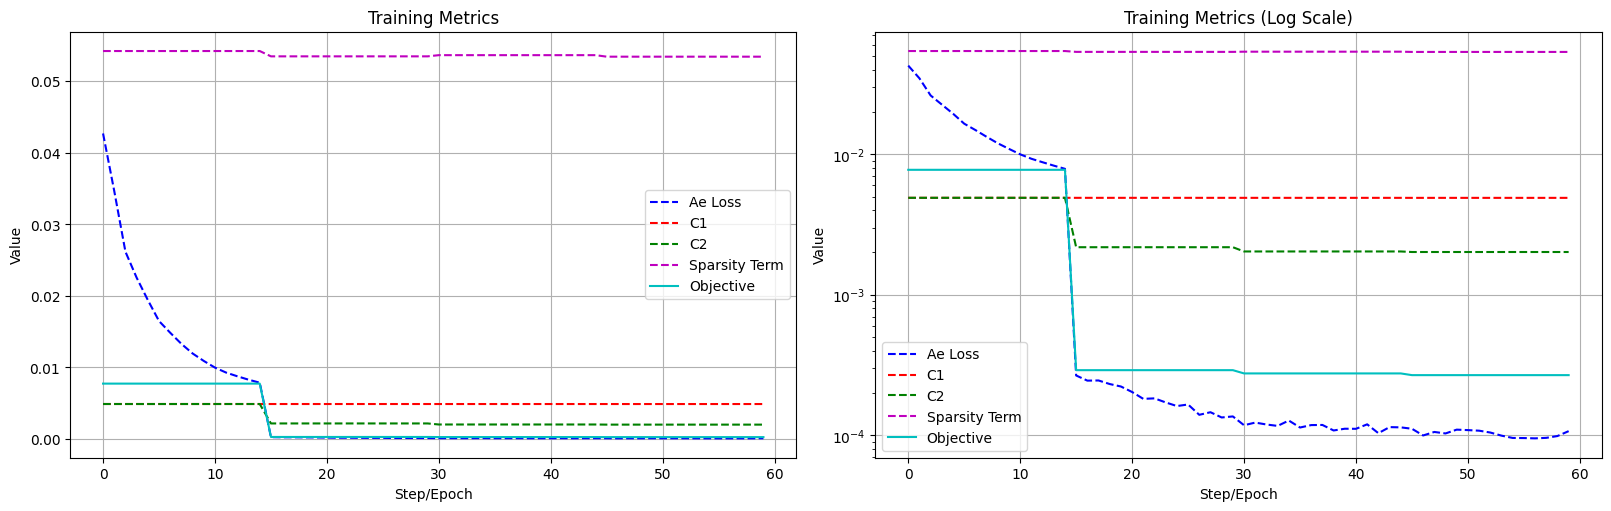

In [5]:
models_dict = {}
rpca = get_model('RPCA', max_iter=6000, lambda_=None, tol=1e-7).to(DEVICE)
ae = get_model('RDA', latent_dim=ae_params['latent_dim'], dropout=ae_params['dropout'], std=ae_params['std']).to(DEVICE)
print(f"Using parameters: {ae_params}\n")

trainer = get_trainer('RDA', ae, i2r_loader)

trainer.fit(
        outer_epochs=ae_params['outer_epochs'], 
        inner_epochs=ae_params['inner_epochs'],
        lr=ae_params['lr'],
        lambda_=ae_params['lambda_']
    )
models_dict['RDA'] = ae

In [ ]:
evaluate_models(test_loader, rpca, models_dict, subject_id=FOOTAGE_ID, results_root=f"./results/i2r/{aug.dest_root.split('/')[-1]}/")


Evaluating on batch of size 200...
No saved results found. Running RPCA Inference...


RPCA Optimization:   1%|          | 41/6000 [00:01<03:58, 25.00it/s, Error=8.05e-08, Min Error=8.05e-08]


RPCA converged in 42 iterations with error 8.05e-08
Saving RPCA results to /home/joshua/P114-Annotation-Free-Segmentation/results/i2r/hall1_Rot10_TPS0_El0/hall1...
Save Complete.
Running Deep Models Inference...
Inference done.



In [ ]:
print("Do you want to save the trained Autoencoder model? (y/n): ", end="")
save_choice = input().strip().lower()
if save_choice == 'y':
    model_name = "rda_model_i2r_3"
    torch.save(ae.state_dict(), f"{model_name}.pth")
    print(f"Model saved as {model_name}.pth")
else:
    print("Model not saved.")